In [1]:
!pip install timm scikit-learn tqdm --quiet

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
import os
import random
import numpy as np
import pickle as pkl


c:\Users\user\Downloads\kiran\kiran\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Config
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
SEED = 42
NUM_CLASSES = 10  # Update based on your dataset (e.g. 7 for HAM)

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Using device: cuda


In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Replace with HAM later
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform_test, download=True)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
from torch.utils.data import Subset

# Select first N samples (say, 1000)
N = 10
indices = list(range(N))
train_subset = Subset(train_dataset, indices)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_subset = Subset(test_dataset, range(2))
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [6]:
model = timm.create_model(
    model_name="vit_base_r50_s16_224",
    pretrained=False,
    num_classes=NUM_CLASSES,
    in_chans=3
).to(device)

In [7]:
class CentralizedTrainer:
    def __init__(self, model, device, lr, save_dir="centralized_logs"):
        self.device = device
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        self.losses = {'train': [], 'test': []}
        self.bal_accs = {'train': [], 'test': []}

    def train_one_epoch(self, dataloader):
        self.model.train()
        running_loss = 0
        all_preds = []
        all_labels = []

        for imgs, labels in tqdm(dataloader):
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        self._log_metrics(all_preds, all_labels, running_loss, len(dataloader), train=True)

    def eval_one_epoch(self, dataloader):
        self.model.eval()
        running_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for imgs, labels in tqdm(dataloader):
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                preds = outputs.argmax(dim=1)
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        self._log_metrics(all_preds, all_labels, running_loss, len(dataloader), train=False)

    def _log_metrics(self, preds, labels, loss_sum, num_batches, train=True):
        phase = 'train' if train else 'test'
        y_true = torch.cat(labels)
        y_pred = torch.cat(preds)
        loss = loss_sum / num_batches
        bal_acc = balanced_accuracy_score(y_true, y_pred)

        self.losses[phase].append(loss)
        self.bal_accs[phase].append(bal_acc)

        print(f"{phase.capitalize()} Loss: {loss:.4f} | Balanced Acc: {bal_acc:.4f}")

    def save_logs(self):
        with open(os.path.join(self.save_dir, "losses.pkl"), "wb") as f:
            pkl.dump(self.losses, f)
        with open(os.path.join(self.save_dir, "balanced_accs.pkl"), "wb") as f:
            pkl.dump(self.bal_accs, f)


In [8]:
trainer = CentralizedTrainer(model, device, LR)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    trainer.train_one_epoch(train_loader)
    trainer.eval_one_epoch(test_loader)

trainer.save_logs()



Epoch 1/10


100%|██████████| 3/3 [00:08<00:00,  2.91s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Train Loss: 4.9014 | Balanced Acc: 0.1875


100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 2.9198 | Balanced Acc: 0.0000

Epoch 2/10


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


Train Loss: 2.4317 | Balanced Acc: 0.1250


100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


Test Loss: 1.6784 | Balanced Acc: 0.5000

Epoch 3/10


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


Train Loss: 2.2790 | Balanced Acc: 0.1250


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


Test Loss: 1.7722 | Balanced Acc: 0.5000

Epoch 4/10


100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


Train Loss: 2.0639 | Balanced Acc: 0.1875


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 2.3273 | Balanced Acc: 0.0000

Epoch 5/10


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Train Loss: 1.9133 | Balanced Acc: 0.1250


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 2.3404 | Balanced Acc: 0.0000

Epoch 6/10


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


Train Loss: 1.5337 | Balanced Acc: 0.2500


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 1.9684 | Balanced Acc: 0.0000

Epoch 7/10


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


Train Loss: 1.2471 | Balanced Acc: 0.6875


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 1.9071 | Balanced Acc: 0.5000

Epoch 8/10


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Train Loss: 1.4062 | Balanced Acc: 0.5000


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 2.3932 | Balanced Acc: 0.0000

Epoch 9/10


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Train Loss: 1.1281 | Balanced Acc: 0.5000


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]
c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Test Loss: 3.2608 | Balanced Acc: 0.0000

Epoch 10/10


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Train Loss: 0.9934 | Balanced Acc: 0.5000


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]

Test Loss: 3.4359 | Balanced Acc: 0.0000



c:\Users\user\Downloads\kiran\kiran\lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [9]:
import matplotlib.pyplot as plt

def plot_training_logs(losses, bal_accs):
    epochs = range(1, len(losses['train']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses['train'], label='Train Loss')
    plt.plot(epochs, losses['test'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    # Balanced Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, bal_accs['train'], label='Train Balanced Acc')
    plt.plot(epochs, bal_accs['test'], label='Test Balanced Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy')
    plt.title('Balanced Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


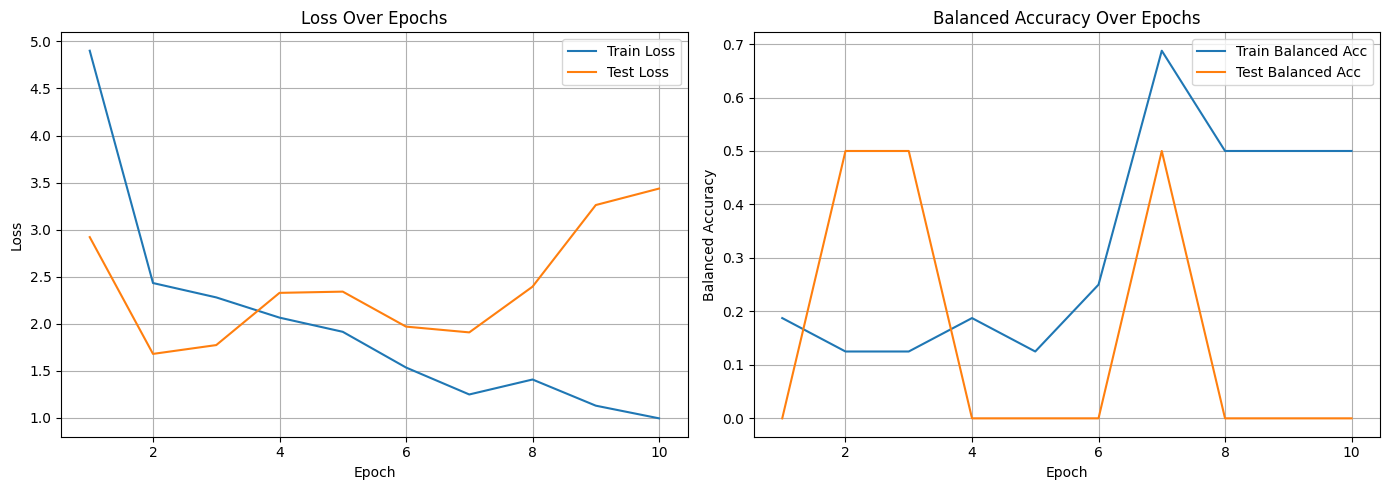

In [10]:
with open("centralized_logs/losses.pkl", "rb") as f: #C:\Users\user\Downloads\kiran\centralized_logs\balanced_accs.pkl
    losses = pkl.load(f)
with open("centralized_logs/balanced_accs.pkl", "rb") as f:
    bal_accs = pkl.load(f)

plot_training_logs(losses, bal_accs)


In [11]:
losses

{'train': [4.901393890380859,
  2.431681275367737,
  2.278991937637329,
  2.0639476776123047,
  1.9132632811864216,
  1.5336604913075764,
  1.2471099297205608,
  1.4061980644861858,
  1.1280773480733235,
  0.9933663209279379],
 'test': [2.919844150543213,
  1.6784236431121826,
  1.7722036838531494,
  2.3272578716278076,
  2.3403639793395996,
  1.968430757522583,
  1.9071252346038818,
  2.3931708335876465,
  3.2608370780944824,
  3.435917615890503]}